# Predicting Forest Cover Types
## Mod 5 - Kaggle Competition - Machine Learning

By Valentina Fontiveros

### Introduction

This dataset was published by Kaggle.
The purpose is to create a model that correctly predict certain types of 
forest cover given environmental descriptors.

### Import Libraries

In [4]:
# data manipulation and calculation libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scaling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Components analysis
from sklearn.decomposition import PCA

# Feature selection
from sklearn.feature_selection import VarianceThreshold

# Models to be used
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Model evaluation Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 


### Read Data

In [6]:
# read data
train = pd.read_csv('train.csv', dtype = 'float')
test = pd.read_csv('test.csv', dtype = 'float')

### Data QC

In [15]:
print('FEATURE NAMES:')
print('')
print(train.columns)
print('')
print('o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o')
print('')
print('NUMBER OF FEATURES:')
print(len(train.columns))

FEATURE NAMES:

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil

In [32]:
# Set Record Id As Index
train.Id.astype('int',inplace=True)
test.Id.astype('int',inplace=True)
train.set_index('Id',inplace=True)  
test.set_index('Id',inplace=True)


/Users/valentina/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/valentina/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/valentina/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


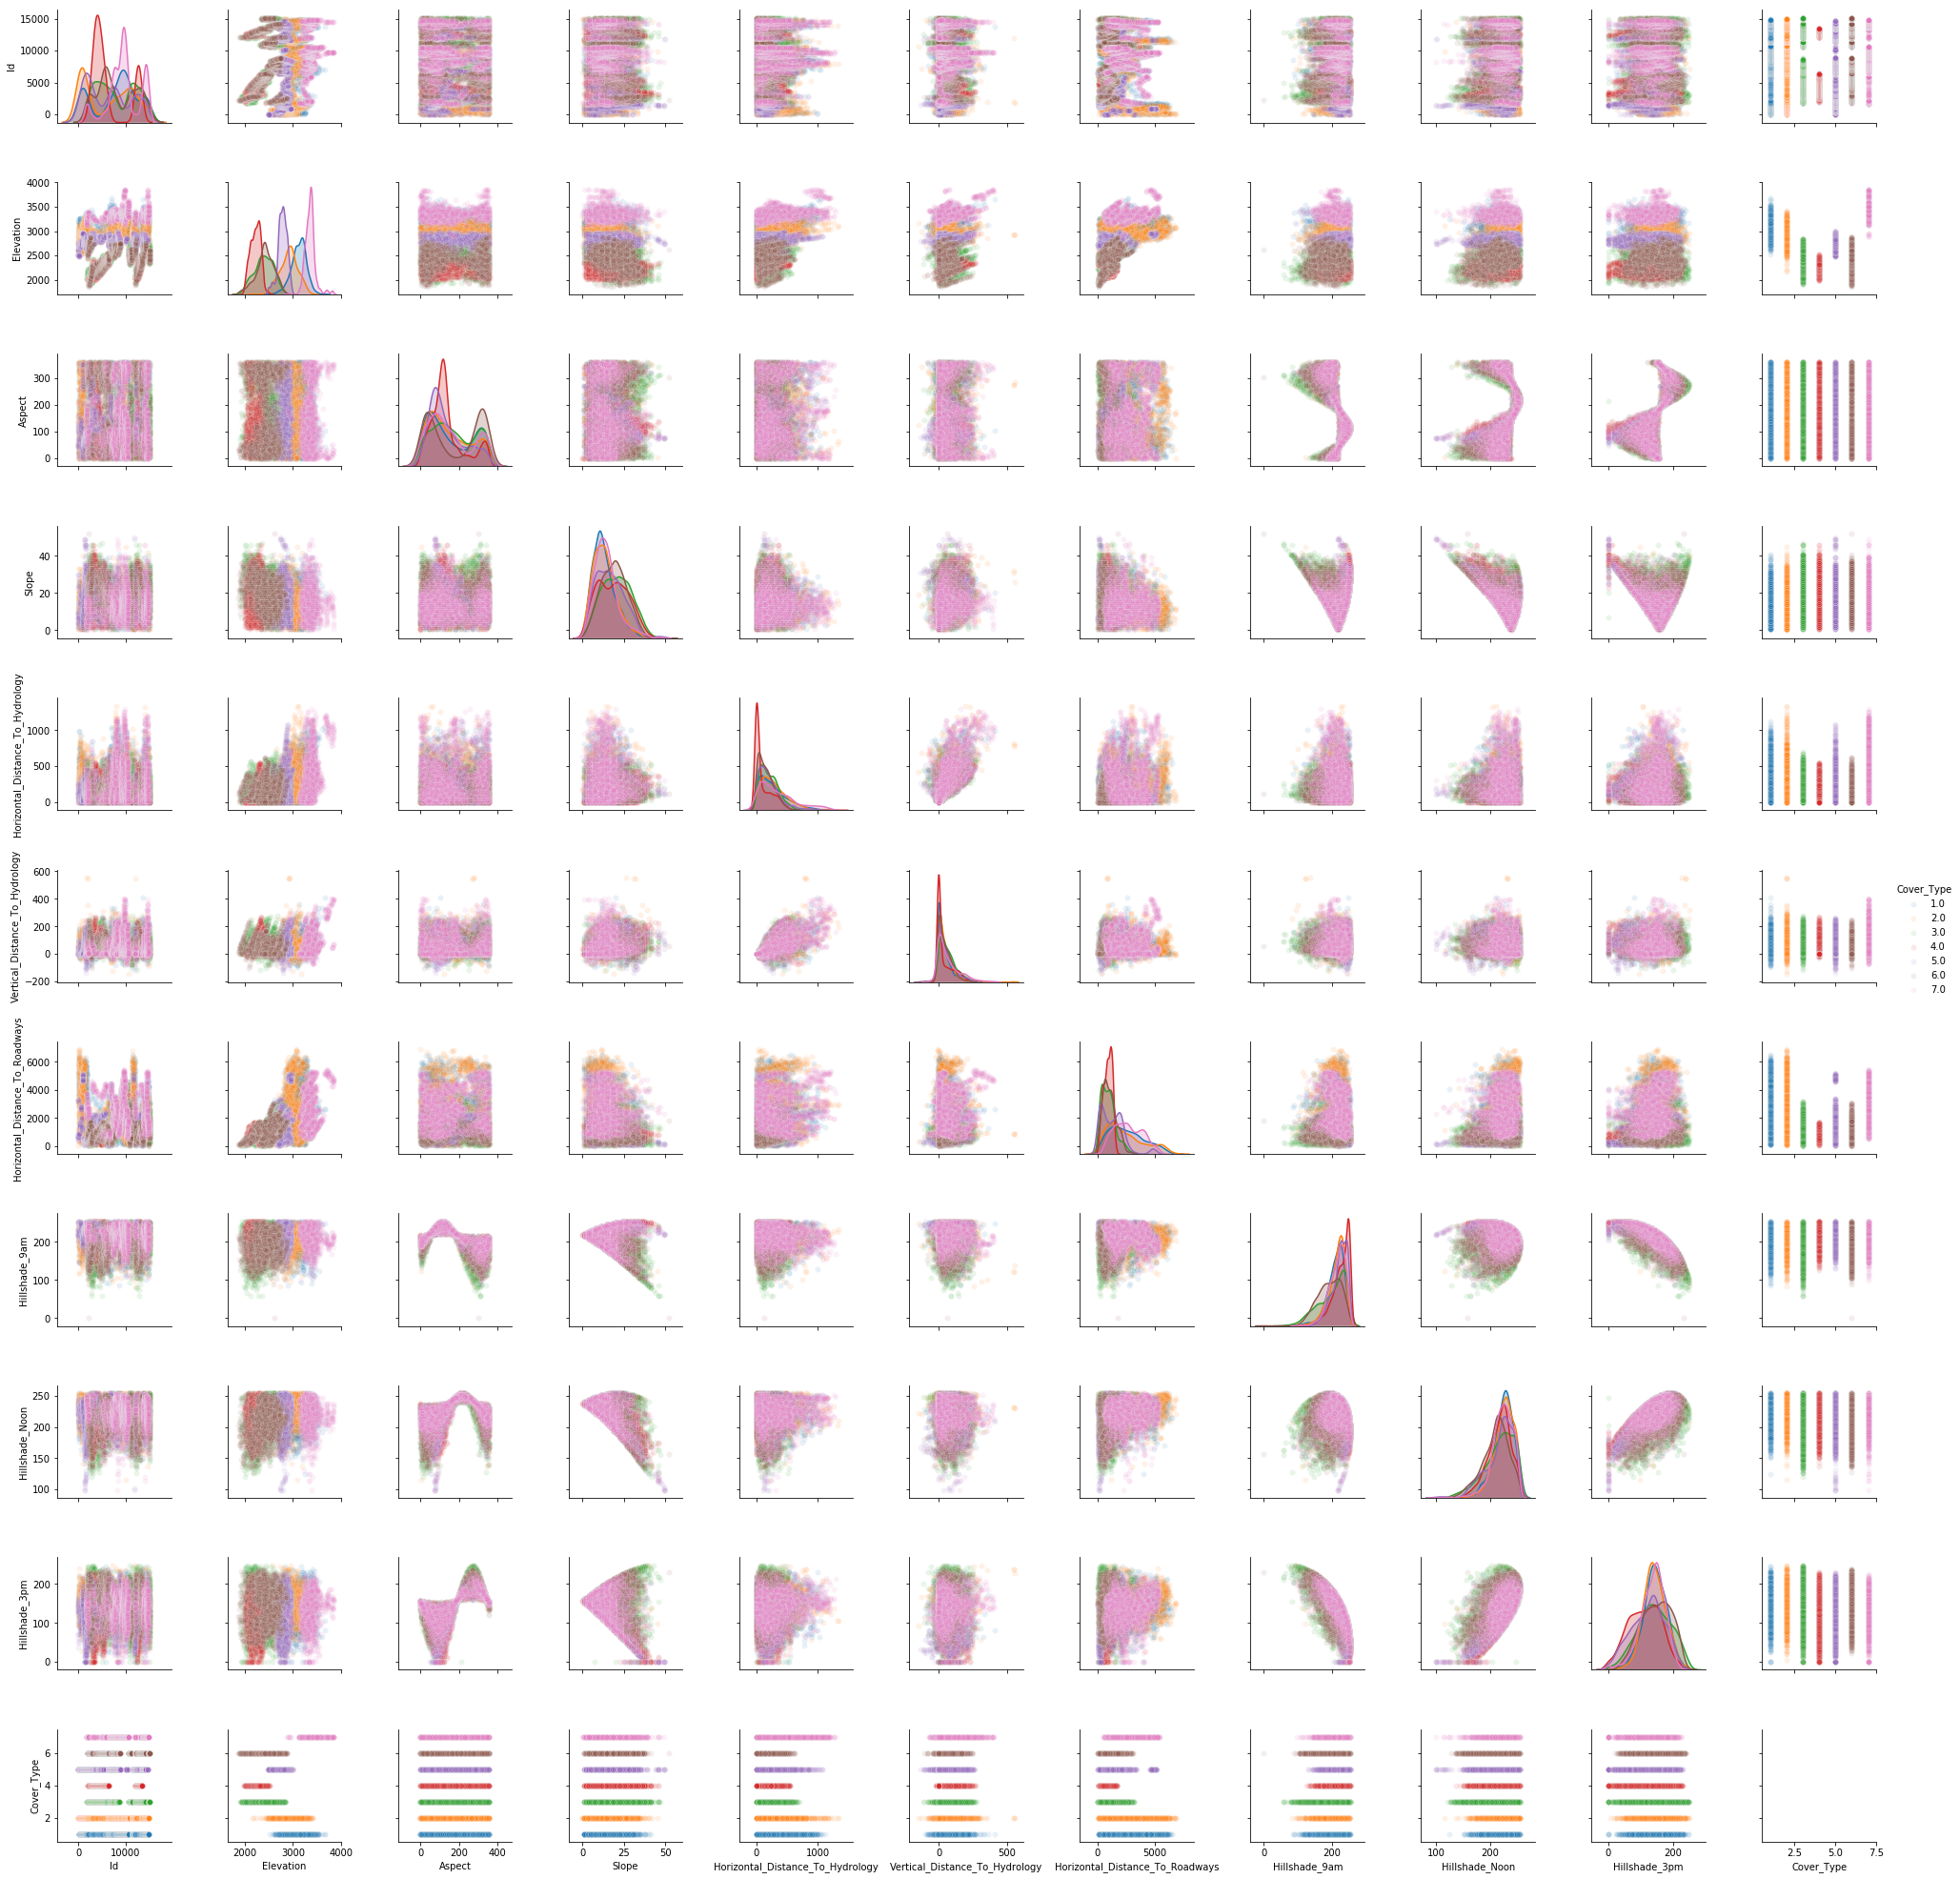

In [16]:
continuous_vars = list(train.columns[0:10])
continuous_vars.append("Cover_Type")

sns.pairplot(train[continuous_vars], kind='scatter', hue="Cover_Type", plot_kws= {'alpha': 0.1})

/Users/valentina/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


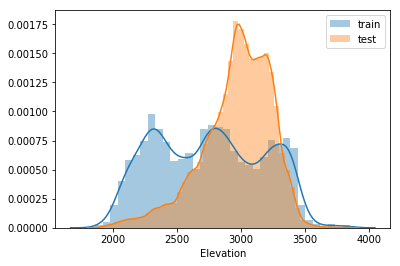

In [54]:
for feature in train.columns[0:1]:
    sns.distplot(train[feature], label='train')
    sns.distplot(test[feature], label='test')
    plt.legend()
    plt.show()

In [ ]:
# after reviewing these distributions, and knowing that elevation is
# a major control on tree species, we should train model on a similar
# distribution
        

In [ ]:
# play visualizations with soil types, wilderness areas, and cover types

In [ ]:
sns.pairplot(pd.DataFrame([train.Elevation,train.Cover_Type]), kind='scatter', hue='Cover_Type', plot_kws= {'alpha': 0.1})

In [52]:
test.Elevation.describe()

count    565892.000000
mean       2964.977407
std         273.157030
min        1859.000000
25%        2818.000000
50%        2999.000000
75%        3164.000000
max        3858.000000
Name: Elevation, dtype: float64

In [53]:
train.Elevation.describe()

count    15120.000000
mean      2749.322553
std        417.678187
min       1863.000000
25%       2376.000000
50%       2752.000000
75%       3104.000000
max       3849.000000
Name: Elevation, dtype: float64

/Users/valentina/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


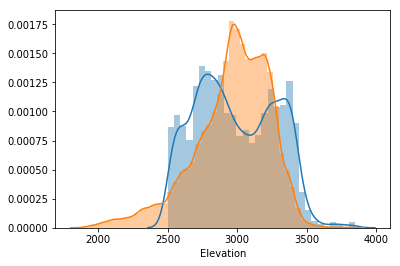

In [65]:
sns.distplot(train[train.Elevation> 2500].Elevation)
sns.distplot(test.Elevation)

### Preprocessing Steps - Scaling

In [36]:

# create a list of features than don't include target/label
features = train.columns[0:-1]

# Format training features and labels - X: features, y: labels
X = train[features]
y_train = train.Cover_Type # Series of Labels

print('Set index as Id and created feature and labeled dataframe.')

Set index as Id and created feature and labeled dataframe.


In [37]:
# Standardization of Data - substracts mean value and divides by variance. 
# Result is in terms of variance ad us kess affected by outliers. Seems best choice.
scaler = StandardScaler()   
scaler.fit_transform(X)   # Scale data

# A Different scaler may be used, but data has many outliers. Thus first scaler preferred.
#scaler2 = MinMaxScaler
#scaler2.fit_transform(X)

# Scale features
X_train = pd.DataFrame(scaler.transform(X))
X_train.columns = X.columns

print('Scaled data using Standard Scaler.')

Scaled data using Standard Scaler.


### Classification Models

In [38]:
# A function that calculates and prints model performance metrics

def performance(y_true, y_predict):
    acc = accuracy_score(y_true, y_predict)
    r2 = r2_score(y_true,y_predict)
    mse = mean_squared_error(y_true,y_predict)
    # Return the score
    return ['Accuracy: ',acc,'R-squared: ', r2,'Mean Squared Error: ',mse]



### Principal Component Analysis

In [ ]:
#pca = PCA(n_components=7)
#pca.fit(X_train)  

In [ ]:
#X_train_PCA = pd.DataFrame(pca.transform(X_train))

### RandomForest

In [39]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
y_train_pred = forest_clf.predict(X_train)
performance(y_train,y_train_pred)
print(forest_clf.feature_importances_)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
X_new.shape               

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


['Accuracy: ',
 0.9943783068783069,
 'R-squared: ',
 0.9880456349206349,
 'Mean Squared Error: ',
 0.047817460317460314]

In [14]:
#test.set_index('Id',inplace=True) 
corr_feats = ['Aspect','Slope','Vertical_Distance_To_Hydrology','Hillshade_3pm','Soil_Type7','Soil_Type15','Soil_Type29','Wilderness_Area1']
test.drop(corr_feats,axis=1,inplace=True)

X_test = pd.DataFrame(scaler.transform(test))
X_test.columns = test.columns

y_test_pred = forest_clf.predict(X_test)

data = [test.index, y_test_pred]

forest_submission = pd.DataFrame(data={'Id':test.index.astype('int'),'Cover_Type':y_test_pred.astype('int')})

# output
forest_submission.to_csv('random_forest.csv',index=False)
forest_submission.head()

In [33]:
# features to be dropped
#corr_feats = ['Aspect','Slope','Vertical_Distance_To_Hydrology','Hillshade_3pm','Hillshade_Noon','Soil_Type7','Soil_Type15','Soil_Type29','Wilderness_Area1']
#train.drop(corr_feats,axis=1,inplace=True)

### K Nearest Neighbors

In [41]:
def find_best_k(X_train, y_train, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_train)
        f1 = accuracy_score(y_train, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("Accuracy Score: {}".format(best_score))

In [42]:
find_best_k(X_train,y_train)

Best Value for k: 1
Accuracy Score: 1.0


In [40]:
kclf = KNeighborsClassifier()
kclf.fit(X_train,y_train)
y_train_pred = kclf.predict(X_train)
print(performance(y_train,y_train_pred))

['Accuracy: ', 0.8845899470899471, 'R-squared: ', 0.7537698412698413, 'Mean Squared Error: ', 0.984920634920635]


In [ ]:
#test.set_index('Id',inplace=True) 
corr_feats = ['Aspect','Slope','Vertical_Distance_To_Hydrology','Hillshade_3pm','Soil_Type7','Soil_Type15','Soil_Type29','Wilderness_Area1']
test.drop(corr_feats,axis=1,inplace=True)

X_test = pd.DataFrame(scaler.transform(test))
X_test.columns = test.columns

y_test_pred = kclf.predict(X_test)

data = [test.index, y_test_pred]

knearest_submission = pd.DataFrame(data={'Id':test.index.astype('int'),'Cover_Type':y_test_pred.astype('int')})
k_nearest_submission.to_csv('k_nearest.csv',index=False)
knearest_submission.head()

### Decision Trees

In [18]:
tclf= DecisionTreeClassifier()
tclf.fit(X_train,y_train) 
y_train_pred = tclf.predict(X_train)
print(performance(y_train,y_train_pred))

['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]


In [20]:
tclf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [19]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_train_pred = regressor.predict(X_train)
print(performance(y_train,y_train_pred))

['Accuracy: ', 1.0, 'R-squared: ', 1.0, 'Mean Squared Error: ', 0.0]


In [21]:

plt.style.use('ggplot')

# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 30, 30, endpoint=True)
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=45)
    regressor.fit(X_train, y_train)
    y_train_pred = regressor.predict(X_train)
    score = performance(y_train, y_train_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12,6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()
plt.show()
plt.figure(figsize=(12,6))
plt.plot(max_depths, mse_results, 'r', label='MSE')
plt.xlabel('Tree Depth')
plt.ylabel('MSE')
plt.legend()
plt.show()


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [22]:
min_samples_splits = np.arange(2,11)
mse_results = []
r2_results = []

for min_samples_split in min_samples_splits:
    regressor = DecisionTreeRegressor(min_samples_split=int(min_samples_split), random_state=45)
    regressor.fit(X_train, y_train)
    y_train_pred = regressor.predict(X_train)
    score = performance(y_train, y_train_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, r2_results, 'b', label='R2')
plt.legend()
plt.show()
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, mse_results, 'r', label='MSE')
plt.legend()
plt.show()

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

### Support Vector Machines

In [23]:
from sklearn import svm

vclf = svm.SVC()
vclf.fit(X_train, y_train)
y_train_pred = vclf.predict(X_train)
print(performance(y_train,y_train_pred))

['Accuracy: ', 0.7358465608465609, 'R-squared: ', 0.3804398148148148, 'Mean Squared Error: ', 2.4782407407407407]


### Ensemble Methods XGBoost

In [24]:
from sklearn.metrics import accuracy_score
clf = xgb.XGBClassifier()


In [25]:
clf.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [26]:
y_train_pred = clf.predict(X_train)
print(performance(y_train,y_train_pred))

['Accuracy: ', 0.7747354497354497, 'R-squared: ', 0.46719576719576716, 'Mean Squared Error: ', 2.1312169312169313]


### Tuning Classifier

In [ ]:
list(range(100,500,50))

In [ ]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [3],
    'min_child_weight': [10],
    'subsample': [1],
    'n_estimators': range(100,500,100)
}

In [ ]:


grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
#val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, y_train_pred)
#val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
#print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

### Submission Formatting

,Id,Cover_Type
0,15121,2
1,15122,2
2,15123,1
3,15124,1
4,15125,1


In [16]:
submission_df.to_csv('fourth_pass.csv',index=False)